# ROOT LOCUS ANALYSIS

This notebook introduces the root locus plot and its application to control design.
The focus is on p-control and closed loop dynamics such as stability, settling time, and oscillations.
The next lecture shows how to address closed loop DC gain.

# Preliminaries

In [1]:
#!pip install -q control

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import control
from typing import List, Tuple, Optional

# Helpers

## plotStep

In [3]:
def plotStep(tf, title:str="", xlim:Optional[list]=None, is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    times, yv = control.step_response(tf)
    plt.plot(times, yv)
    if xlim is not None:
        plt.xlim(xlim)
    plt.title(title)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([1], [1, 1])
plotStep(tf, is_plot=False, xlim=[0, 3])
print("OK!")

OK!


## complex_magnitude

In [4]:
def complex_magnitude(z):
    return (z.real**2 + z.imag**2)**0.5

In [5]:
4j

4j

In [6]:
def ppComplex(complexes:List[complex], round_digits=3)->str:
    """
    Constructs a pretty print representation of a complex number.
    """
    results = []
    for complex in complexes:
        if np.imag(complex) == 0:
            results.append(str(np.real(complex)))
        else:
            results.append(str(round(np.real(complex), round_digits)) + "+" + str(round(np.imag(complex), round_digits)) + "j")
    return ", ".join(results)

# Tests
result = ppComplex([3+2j, 4])
assert("j" in result)
print("OK!")

OK!


## plotRootLocusWithGains

In [7]:
def plotRootLocusWithGains(open_loop_transfer_function:control.TransferFunction,
      gains:List[float],
      xlim:Optional[np.ndarray]=None,
      title:Optional[str]=None, 
      ylim:Optional[np.ndarray]=None,
      is_annotate:bool=True,
      markersize_multiplier:float=100,
      figsize=(5, 5),
      is_plot:bool=True):
    """
    Constructs a root locus plot with red hexagons for closed loop poles at different gains.
    Poles at specific gains are indicated by hexigon markers.

    Args:
        open_loop_transfer_function
        gains
        xlim: limits on the axis
        size_multiplier: multiplies by gain to get size of hexagon that marks the pole
        figsize: width and height of figure
        is_annotate: Annotate gain hexigons with gain values
    """
    _, ax = plt.subplots(1, 1, figsize=figsize)
    # Plot the root locus
    _ = control.root_locus(open_loop_transfer_function, grid=False, plot=True, xlim=xlim, 
          ylim=ylim, ax=ax)
    # Construct the title
    if title is None:
        poles = open_loop_transfer_function.poles()
        zeros = open_loop_transfer_function.zeros()
        title = ""
        if len(poles) > 0:
            title += f"poles: {ppComplex(poles)}  "
        if len(zeros) > 0:
            title += f"zeros: {ppComplex(zeros)}"
    ax.set_title(title)
    # Add points for closed loop poles
    for gain in gains:
        closed_loop_transfer_function = control.feedback(gain*open_loop_transfer_function)
        poles = closed_loop_transfer_function.poles()
        xv = []
        yv = []
        for pole in poles:
            xv.append(pole.real)
            yv.append(pole.imag)
        if is_annotate:
            annotation = str(gain)
        else:
            annotation = ""
        ax.scatter(xv, yv, s=markersize_multiplier*gain, marker="h", color="r")
        [ ax.annotate(annotation, (xv[i], yv[i]), color='blue', rotation=25)
             for i in range(len(poles))]
        arrowprops=dict(facecolor='black', shrink=0.05)
    #
    if not is_plot:
        plt.close()

# Tests
tf = control.zpk([1], [-1, -2], [1])
plotRootLocusWithGains(tf, [0.2, 0.5], markersize_multiplier=200, ylim=[-3, 3], xlim=[-3.5, 0], is_annotate=True, 
      figsize=(2, 2), is_plot=False)
print("OK!")

OK!


# Root Locus Analysis

## Motivation

In [8]:
# An alternative way to construct a transfer function by specifying: 
#    zeros, poles, multiplier times the transfer function
OL_TF = control.zpk([], [-2], [5])
OL_TF

TransferFunction(array([5.]), array([1., 2.]))

Let $G(s)$ be the open loop transfer function and $H(s)$ be the closed loop transfer function for p-control.
That is, $C(s) = k_P$. Consider the first order system $G(s) = \frac{k}{s - p}$.
\begin{eqnarray}
H(s) & = & \frac{C(s) G(s)}{1 + C(s) G(s)} \\
 & = & \frac{k_P k}{s - p + k_P k} \\
\end{eqnarray}

In [9]:
# Now create the closed loop transfer function for p-control with a gain of kP
kP = 2
cl_tf = control.feedback(kP*OL_TF) # Calculates H(s)
cl_tf

TransferFunction(array([10.]), array([ 1., 12.]))

We can compare choices for $k_P$ by calculating the transfer functions for different $k_P$.

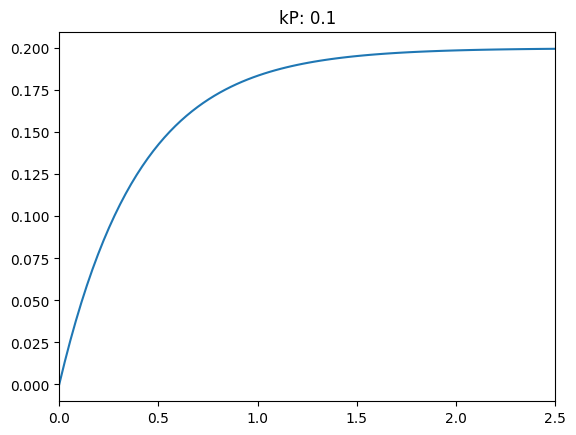

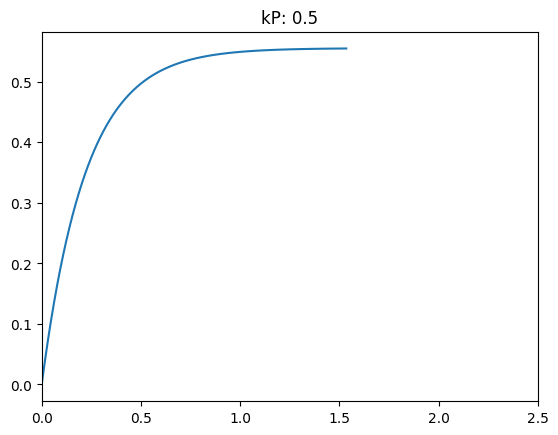

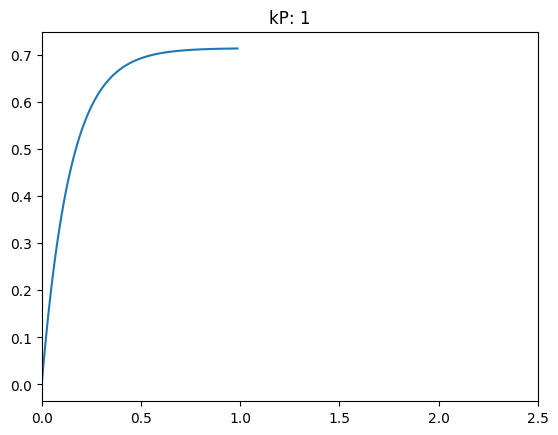

In [10]:
for kP in [0.1, 0.5, 1]:
    cl_tf = control.feedback(kP*OL_TF) # Calculates H(s)
    plt.figure()
    plotStep(cl_tf, title=f"kP: {str(kP)}", xlim=[0, 2.5])

This is cumbersome and time consuming if we want to compare many designs. Also, it gives no insight into the effect of $k_P$.

**We want a more direct way to see the closed loop poles as $k_P$ is changed.**

## Root locus plots

The root locus plot displays the poles of the *closed loop* transfer function for the open loop under p-control.
* Open loop poles are indicated by an "X"
* Open loop zeros are indicated by a red circle
* Blue lines are "branches" the path of closed loop poles as $k_P$ is changed

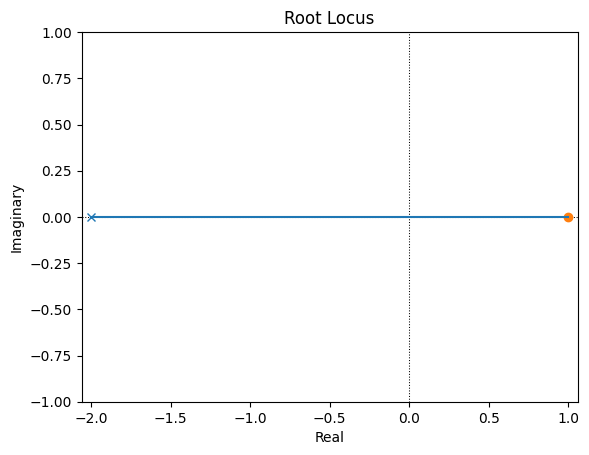

In [11]:
ol_tf = control.zpk([1], [-2], [5])
_ = control.root_locus(ol_tf, grid=False)

It's more insightful to annotate the plot with the poles as $k_P$ is varied.

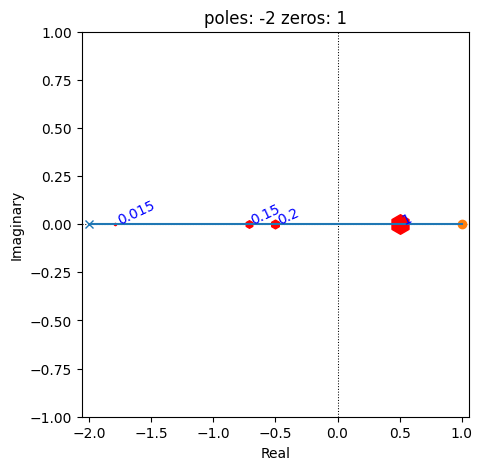

In [12]:
ol_tf = control.zpk([1], [-2], [5])
plotRootLocusWithGains(ol_tf, gains=[0.015, 0.15, 0.2, 1], markersize_multiplier=200, title="poles: -2 zeros: 1",
     is_annotate=True)

**Questions**
1. Where are the open loop poles and zeros?
1. How many branches are there?
2. Where does the branch start? Where does it end?
1. How do the poles "travel" as gain is increased?

There is one branch for each open loop pole. A single value of $k_P$ results in a new pole on each branch.

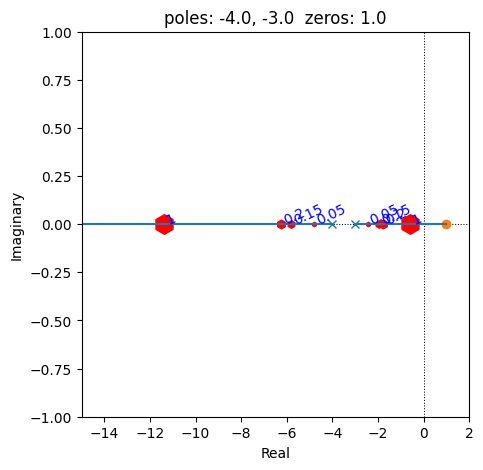

In [13]:
ol_tf = control.zpk([1], [-3, -4], [5])
plotRootLocusWithGains(ol_tf, gains=[0.05, 0.15, 0.2, 1], markersize_multiplier=200,
    xlim=[-15, 2], is_annotate=True)

**Questions**
1. Where are the open loop poles and zeros?
1. How many branches are there?
1. How do the closed loop poles move as $k_P$ is increased?
1. Are the closed loop poles bounded as we increase $k_P$?

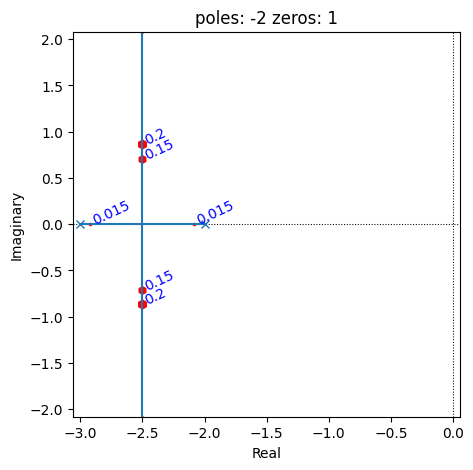

In [14]:
ol_tf = control.zpk([], [-2, -3], [5])
plotRootLocusWithGains(ol_tf, gains=[0.015, 0.15, 0.2, 1], markersize_multiplier=200, title="poles: -2 zeros: 1",
     is_annotate=True)

**Questions**
1. Where are the open loop poles and zeros?
1. How many branches are there?
1. How do the closed loop poles move as $k_P$ is increased?
1. Are the closed loop poles bounded as we increase $k_P$?

A point at which a branch leaves the x-axis is a **breakaway point**.
A point at which a branch joins the x-axis is a **breakin point**.

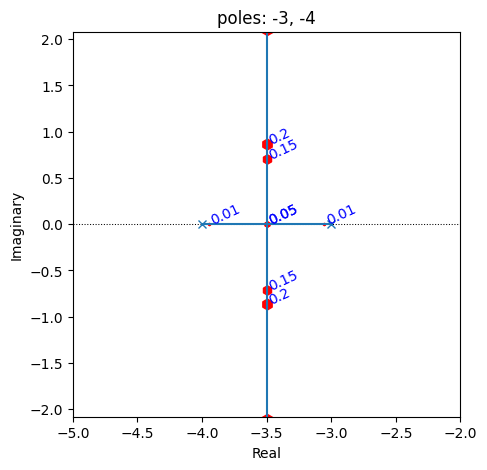

In [15]:
ol_tf = control.zpk([], [-3, -4], [5])
plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300, title="poles: -3, -4",
    xlim=[-5, -2], is_annotate=True)

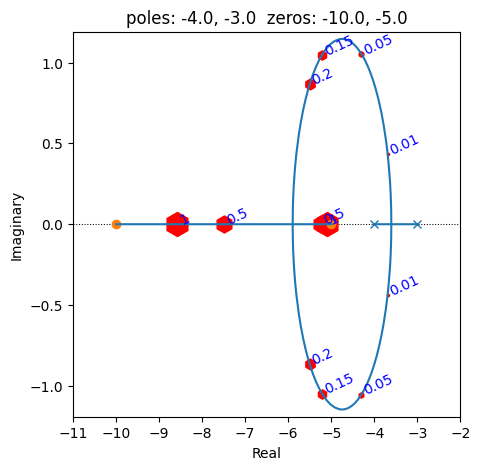

In [16]:
ol_tf = control.zpk([-5, -10], [-3, -4], [5])
plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 0.5, 1], markersize_multiplier=300,
    xlim=[-11, -2], is_annotate=True)

**Questions about this plot**
1. Where do the branches start?
2. Where do the branches end?
1. How many branches are there?
2. What is the breakaway point?
3. What is the breakin point?
4. How do the branches travel after the breakin point?

# Understanding Root Locus Plots

## 1. Branches begin at open loop poles and terminate at open loop zeros or infinity.

$$H(s) = \frac{k_P G(s)}{1 + k_P G(s)}$$

Let $G(s) = \frac{N(s)}{D(s)}$, where $D(s) = 0$ is the open loop characteristic equation.
Then
$$H(s) = \frac{k_P N(s)}{D(s) + k_P N(s)}$$

**Questions**
1. What are the poles of $H(s)$ when $k_P$ is very small?
1. What are the poles of $H(s)$ when $k_P$ is very large?

## 2. The root locus plot is symmetric about the x-axis.

This follows from the fact that since transfer functions have real valued coefficients, complex solutions for $s$ must include their complex conjugates. Complex conjugates are symmetric w.r.t. the x-axis.

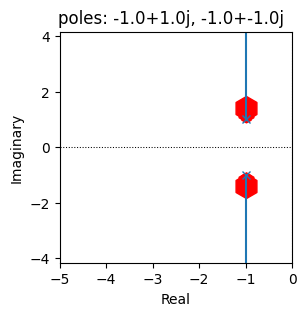

In [17]:
ol_tf = control.zpk([], [-1+1j, -1-1j], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3), 
    xlim=[-5, 0], is_annotate=False)

## 3. Location of branches

Let $s$ be a point on the real axis. $s$ is a closed pole for some $k_P$ if there are an odd number of poles
and zeros to its right on the real axis

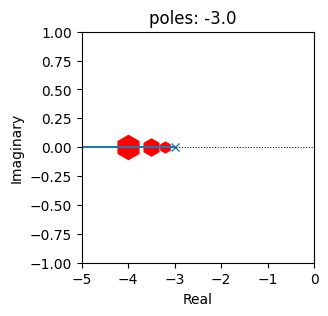

In [18]:
ol_tf = control.zpk([], [-3], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3), 
    xlim=[-5, 0], is_annotate=False)

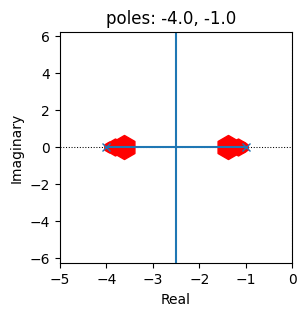

In [19]:
ol_tf = control.zpk([], [-4, -1], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3), 
    xlim=[-5, 0], is_annotate=False)

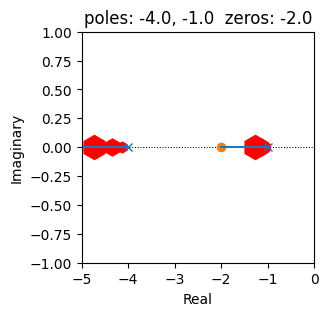

In [20]:
ol_tf = control.zpk([-2], [-4, -1], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3), 
    xlim=[-5, 0], is_annotate=False)

**Proof**: 
We know that for $s$ to be a pole, it must satisfy $1 + G(s) = 0$ or $G(s) = -1$.
$G(s) = \frac{\prod_m (s - z_m)}{\prod_n (s - p_n)}$.

For $G(s)$ to be negative, an odd number $z_m, p_n$ must be negtive.
That is an odd number of open loop poles and zeros must be to the right $s$.

## 4. Angle of asymptotes is $\alpha$ s.t. $(N_P - N_Z) \alpha = \pm 180 + k*360$, for $k \in \{0, 1, 2, \cdots \}$

$N_P$ is the number of open loop poles; $N_Z$ is the number of open loop zeros.


**Example 1**: $G(s) = \frac{1}{s + 3}$
* $N_P =1$, $N_Z = 0$.
* One asymptote. On x-axis to $-\infty$

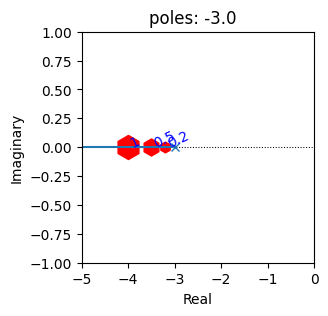

In [21]:
ol_tf = control.zpk([], [-3], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3), 
    xlim=[-5, 0], is_annotate=True)

**Example 2**: $G(s) = \frac{s + 1}{s + 3}$
* $N_P =1$, $N_Z = 1$.
* No asymptote.

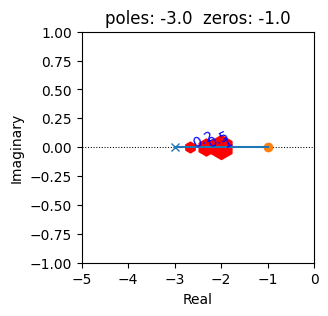

In [22]:
ol_tf = control.zpk([-1], [-3], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3), 
    xlim=[-5, 0], is_annotate=True)

**Example 3**: $G(s) = \frac{s + 1}{s + 3}(s + 4)$
* $N_P =2$, $N_Z = 1$.
* One asymptote on x-axis to $-\infty$.

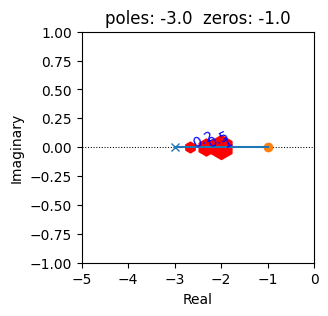

In [23]:
ol_tf = control.zpk([-1], [-3], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3), 
    xlim=[-5, 0], is_annotate=True)

**Example 4**: $G(s) = \frac{s + 1}{s + 3}(s + 4)$
* $N_P =2$, $N_Z = 1$.
* One asymptote on x-axis to $-\infty$.

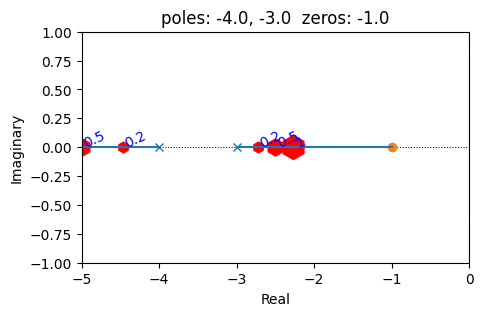

In [24]:
ol_tf = control.zpk([-1], [-3, -4], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(5, 3), 
    xlim=[-5, 0], is_annotate=True)

**Proof**:
For large $s$, its angle with all poles and zeros is the same. We denote this angle by $\alpha$.
That is,
\begin{eqnarray}
\angle \left( \frac{N(s)}{D(s)} \right) & = & 180  \\
\alpha N_Z  - \alpha N_P  & = & 180\\
\alpha & = & -\frac{180}{N_P - N_Z} 
\end{eqnarray}
Note that $\alpha + k 360 = \alpha$, for $k = 0, \pm1, \pm2, \cdots$.

Note: There is no asymptote if $N_P = N_Z$.

# Designing P Control With Root Locus

**Design objective: Minimize the dominant.**

Using root locus for designing p-control.
1. Draw the (annotated) root locus plot.
2. Find the value of $k_P$ that minimizes the dominant pole.

## $N_P = 1, N_Z = 0$.

**Approach**: Maximize $k_P$ since the asymptote for closed loop poles goes to $-\infty$

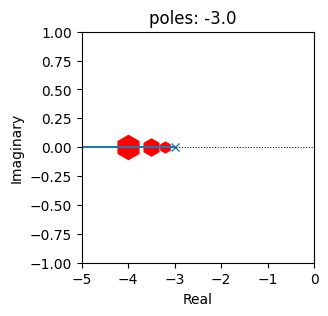

In [25]:
ol_tf = control.zpk([], [-3], [1])
plotRootLocusWithGains(ol_tf, gains=[0.2, 0.5, 1], markersize_multiplier=300, figsize=(3, 3), 
    xlim=[-5, 0], is_annotate=False)

## $N_P = 2, N_Z = 0$

**Approach**: Find $k_P$ for the breakaway point.

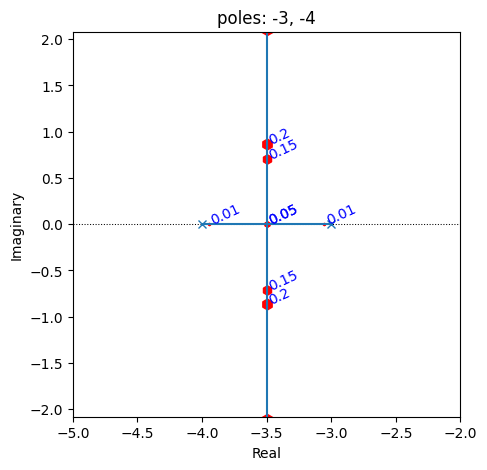

In [26]:
ol_tf = control.zpk([], [-3, -4], [5])
plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300, title="poles: -3, -4",
    xlim=[-5, -2], is_annotate=True)

## $N_P = 2, N_Z = 1$

**Approach**: 
1. If $z > max(p_1, p_2)$, minimize $k_P$.
2. If $p_1 < z < p_2$, choose $k_P$ so that dominant closed loop pole is close to $z$.
3. If $z < p_1 < p_2$, choose $k_P$ at the breakin point.

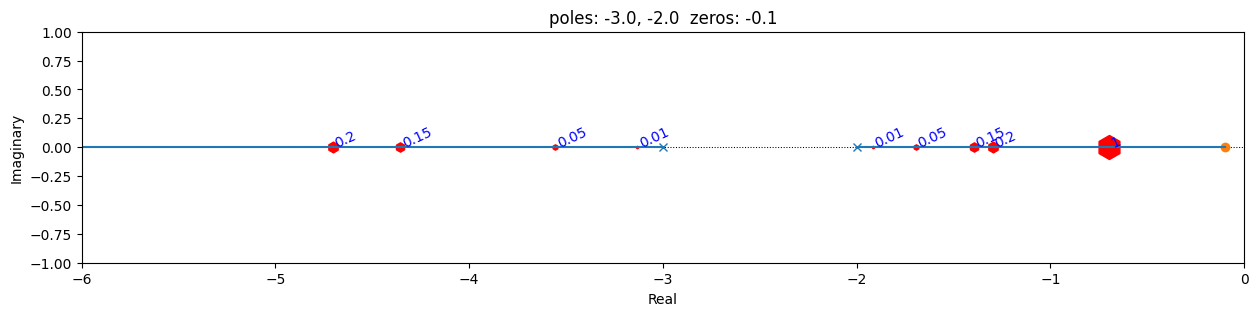

In [27]:
# Case 1: p1, p2 < z
ol_tf = control.zpk([-0.1], [-2, -3], [5])
plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300,
    xlim=[-6, 0], figsize=(15, 3), is_annotate=True)

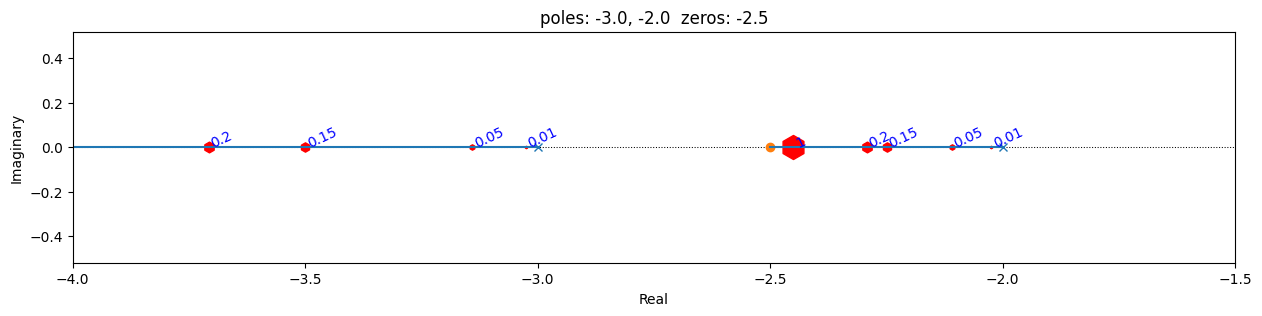

In [28]:
# Case 2: p1 < z < p2
ol_tf = control.zpk([-2.5], [-2, -3], [5])
plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300,
    xlim=[-4, -1.5], figsize=(15, 3), is_annotate=True)

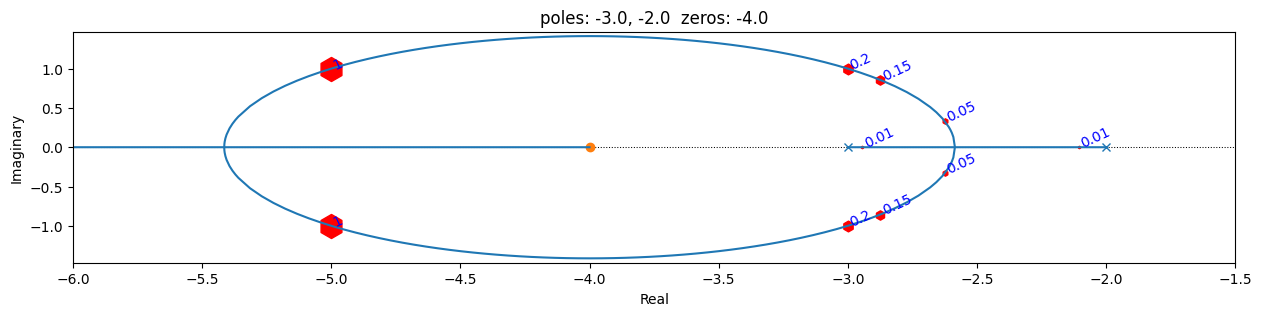

In [29]:
# Case 3: z < p1, p2
ol_tf = control.zpk([-4], [-2, -3], [5])
plotRootLocusWithGains(ol_tf, gains=[0.01, 0.05, 0.15, 0.2, 1], markersize_multiplier=300,
    xlim=[-6, -1.5], figsize=(15, 3), is_annotate=True)